# Homework 04: Building CNNs for Image Classification

## Due: Midnight on September 28 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects. 

There are 10 graded questions, worth 8 points each, with 5 points free if you complete the homework. 


## 1. Setup and Data Loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-09-25 01:03:51.781922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 01:03:52.126413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 01:03:53.578153: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [3]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default 
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,                  
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),      
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  



In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

In [5]:
# Reproducible load + preprocess for Intel Image Classification

# -------------------------
# Loader (deterministic)
# -------------------------
def load_data_from_directory(directory, img_size=(150, 150), class_names=None):
    """
    Loads images as float32 in [0,1] and integer labels.
    Sorting ensures deterministic order. If class_names is provided,
    that ordering defines label indices.
    Returns: X, y, class_names_used
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # Ensure only classes present in directory are used (robustness)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        # Sort filenames so load order is reproducible
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            # Explicit interpolation for consistency
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img)  # float32
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = (np.array(X, dtype="float32") / 255.0)   # normalize to [0,1]
    y = np.array(y, dtype="int32")               # integer labels
    return X, y, class_names

def show_counts(name, y_arr):
    c = Counter(y_arr.tolist() if hasattr(y_arr, "tolist") else y_arr)
    print(f"{name} per-class counts:", dict(c))

# -------------------------
# Download & paths
# -------------------------
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

# -------------------------
# Load train (get class_names) & test using same mapping
# -------------------------
X_train_all, y_train_all, class_names = load_data_from_directory(train_dir, img_size=(150,150))
X_test,       y_test,   _            = load_data_from_directory(test_dir, img_size=(150,150), class_names=class_names)

num_classes = len(class_names)
print("class_names:", class_names)
print("X_train_all:", X_train_all.shape, "y_train_all:", y_train_all.shape)
print("X_test:     ", X_test.shape,      "y_test:     ", y_test.shape)

# -------------------------
# Stratified train/val split (reproducible)
# -------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True
)

class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train_all: (14034, 150, 150, 3) y_train_all: (14034,)
X_test:      (3000, 150, 150, 3) y_test:      (3000,)


### Examine The Dataset

In [6]:
print("X_train:",  X_train.shape,  "y_train:",  y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

X_train: (11227, 150, 150, 3) y_train: (11227,)
X_val: (2807, 150, 150, 3) y_val: (2807,)
train per-class counts: {0: 1753, 4: 1819, 2: 1923, 1: 1817, 5: 1906, 3: 2009}
val   per-class counts: {1: 454, 2: 481, 3: 503, 0: 438, 4: 455, 5: 476}
test  per-class counts: {0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


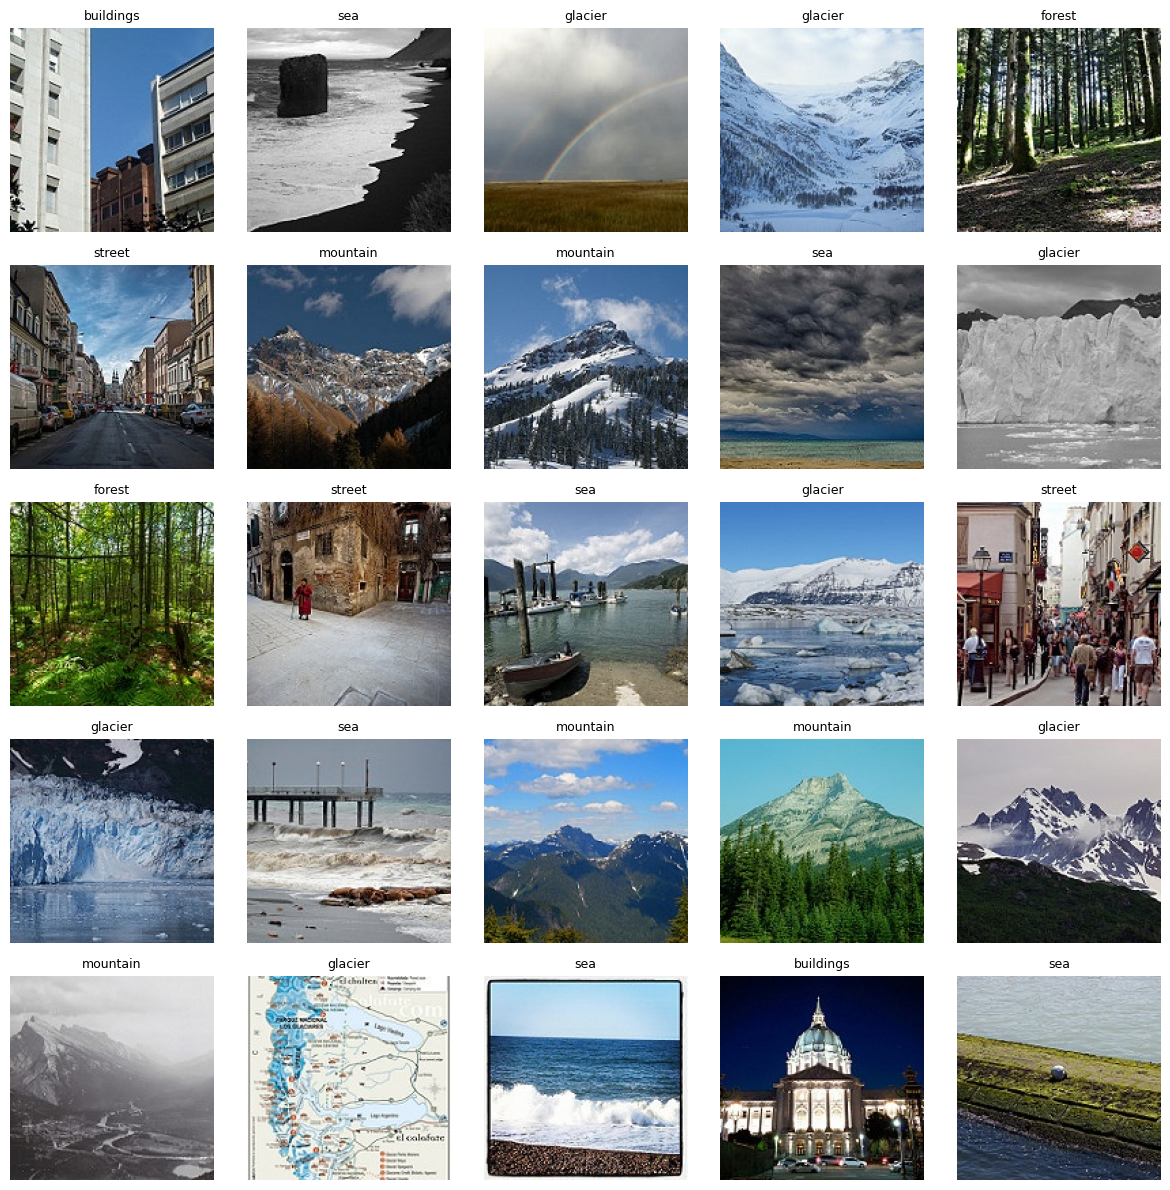

In [7]:
# Show a 5×5 grid of the first 25 training images
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[i])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!). 

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in. 


I0000 00:00:1758787447.286307     990 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9



Baseline Model



2025-09-25 01:04:11.577055: I external/local_xla/xla/service/service.cc:163] XLA service 0x71feec01cf10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-25 01:04:11.577103: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-25 01:04:11.600660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-25 01:04:11.707661: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1758787455.726591    1163 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


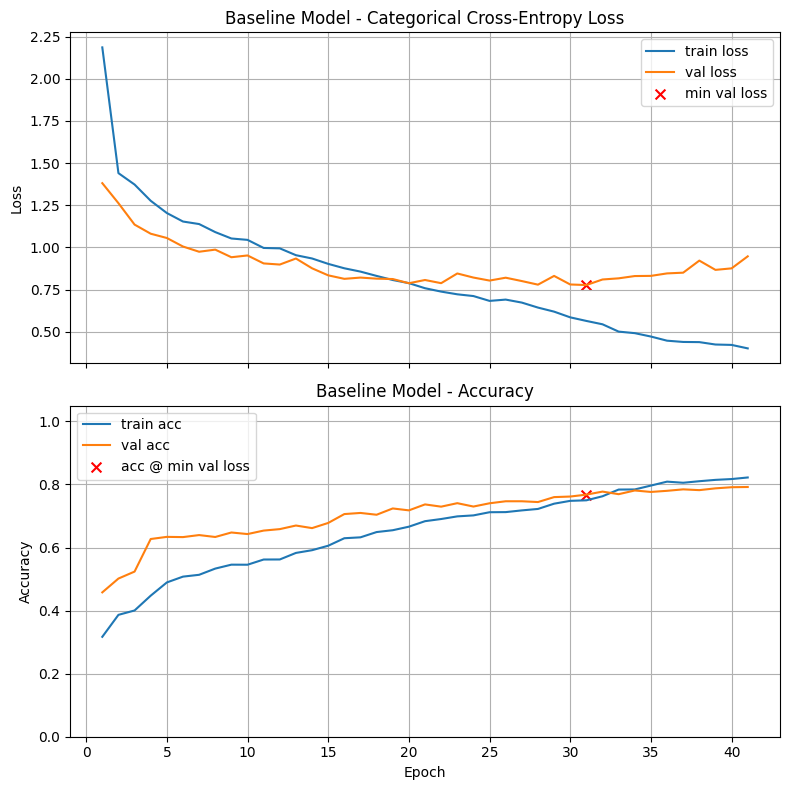

Final Training Loss:            0.4013
Final Training Accuracy:        0.8221
Final Validation Loss:          0.9470
Final Validation Accuracy:      0.7919
Minimum Validation Loss:        0.7768 (Epoch 31)
Validation Accuracy @ Min Loss: 0.7677


2025-09-25 01:05:51.946236: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 12 bytes spill stores, 12 bytes spill loads

2025-09-25 01:05:52.044570: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 4 bytes spill stores, 4 bytes spill loads




Test Loss: 0.7645
Test Accuracy: 0.7590

Validation-Test Gap (accuracy): 0.008724

Execution Time: 00:01:44


In [8]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),            
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title="Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer. 
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5). 


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).


Problem 1 -- Baseline CNN



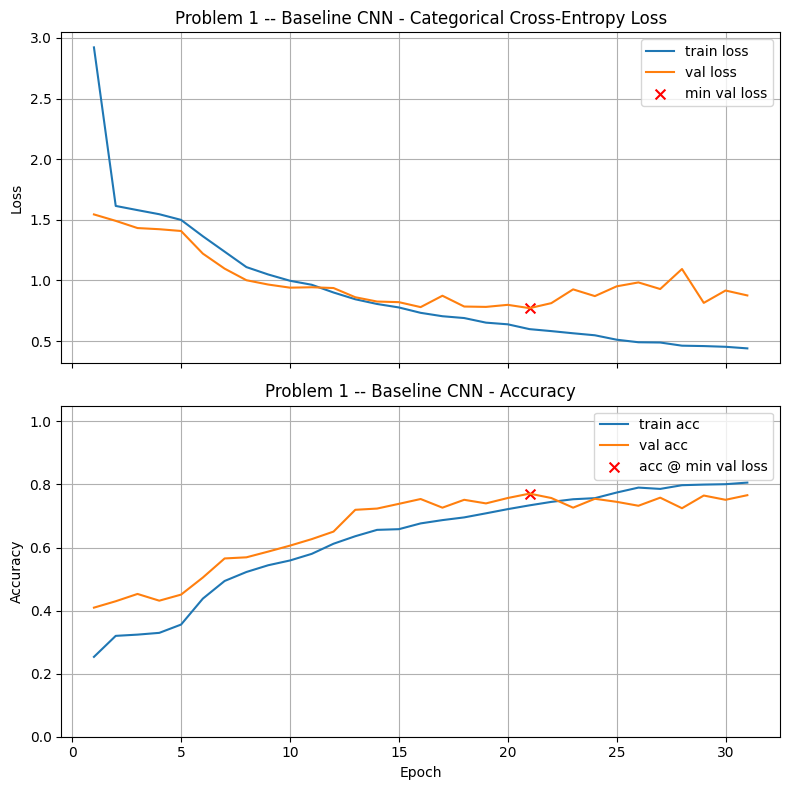

Final Training Loss:            0.4397
Final Training Accuracy:        0.8059
Final Validation Loss:          0.8764
Final Validation Accuracy:      0.7659
Minimum Validation Loss:        0.7715 (Epoch 21)
Validation Accuracy @ Min Loss: 0.7709

Test Loss: 0.7551
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.005930

Execution Time: 00:01:14

Problem 1 -- Tweak 1 -- lr: 0.0005



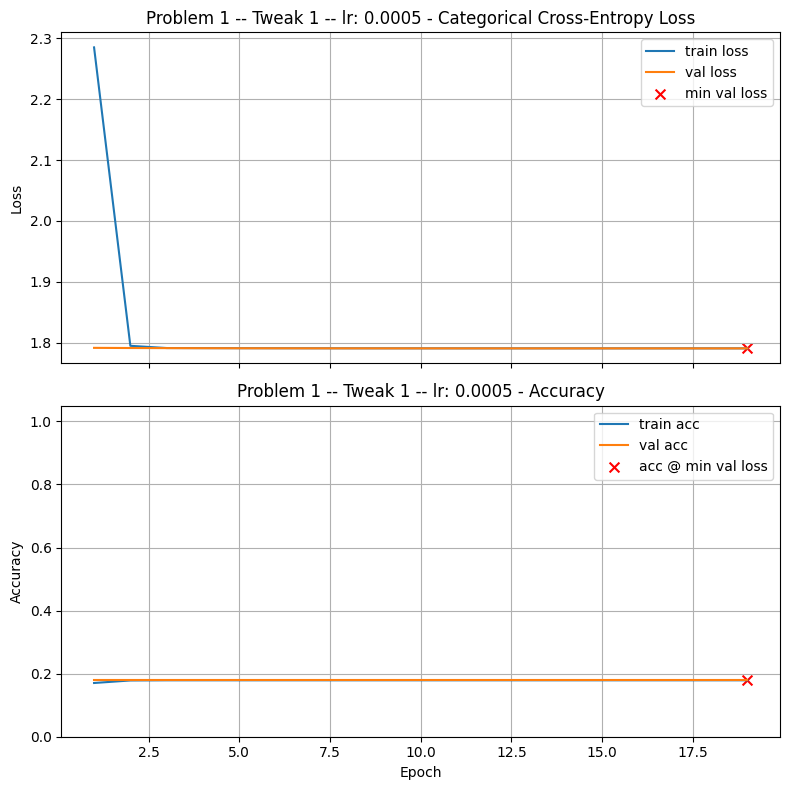

Final Training Loss:            1.7908
Final Training Accuracy:        0.1789
Final Validation Loss:          1.7907
Final Validation Accuracy:      0.1792
Minimum Validation Loss:        1.7907 (Epoch 19)
Validation Accuracy @ Min Loss: 0.1792

Test Loss: 1.7903
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004195

Execution Time: 00:00:49

Problem 1 -- Tweak 2 -- wider Conv2D



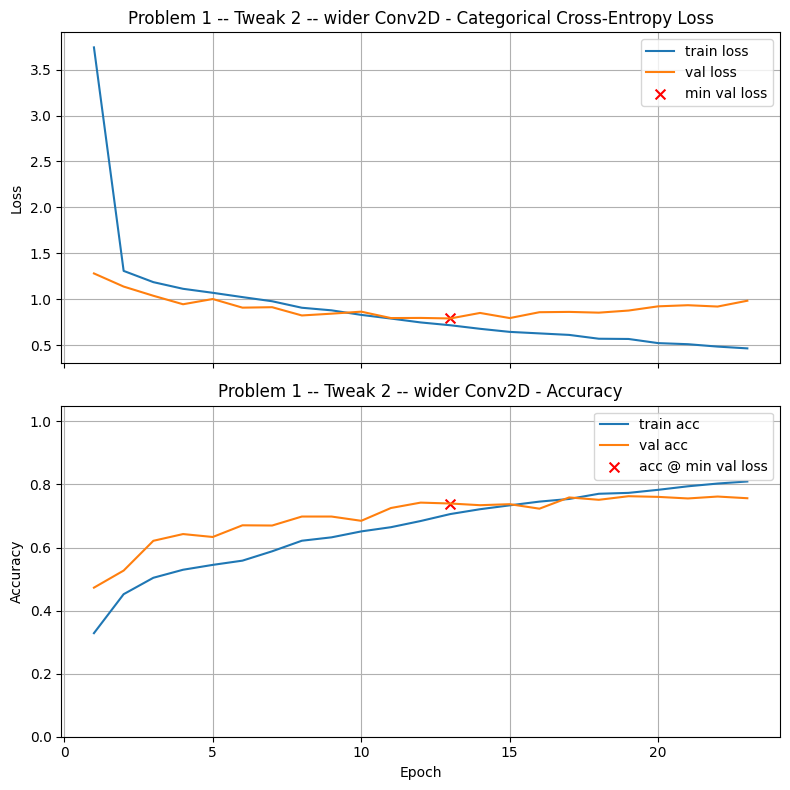

Final Training Loss:            0.4641
Final Training Accuracy:        0.8095
Final Validation Loss:          0.9831
Final Validation Accuracy:      0.7563
Minimum Validation Loss:        0.7901 (Epoch 13)
Validation Accuracy @ Min Loss: 0.7396

Test Loss: 0.7740
Test Accuracy: 0.7390

Validation-Test Gap (accuracy): 0.000580

Execution Time: 00:01:36

Problem 1 -- Tweak 6 -- dropout: 0.3



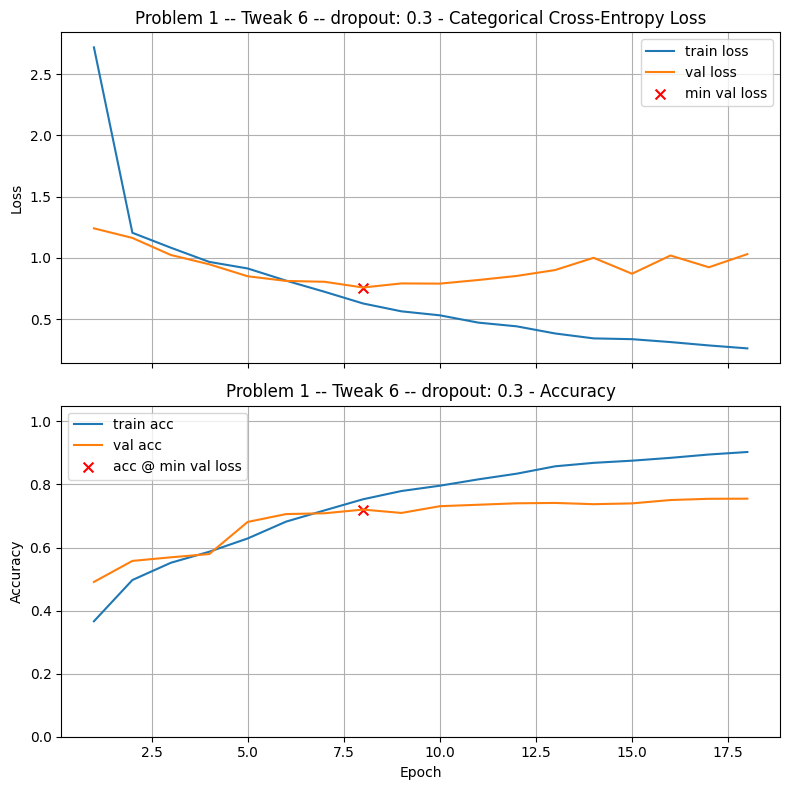

Final Training Loss:            0.2603
Final Training Accuracy:        0.9029
Final Validation Loss:          1.0300
Final Validation Accuracy:      0.7549
Minimum Validation Loss:        0.7576 (Epoch 8)
Validation Accuracy @ Min Loss: 0.7203

Test Loss: 0.7804
Test Accuracy: 0.7237

Validation-Test Gap (accuracy): 0.003325

Execution Time: 00:00:46

Problem 1 -- Combined -- lr: 0.0005 dropout: 0.3



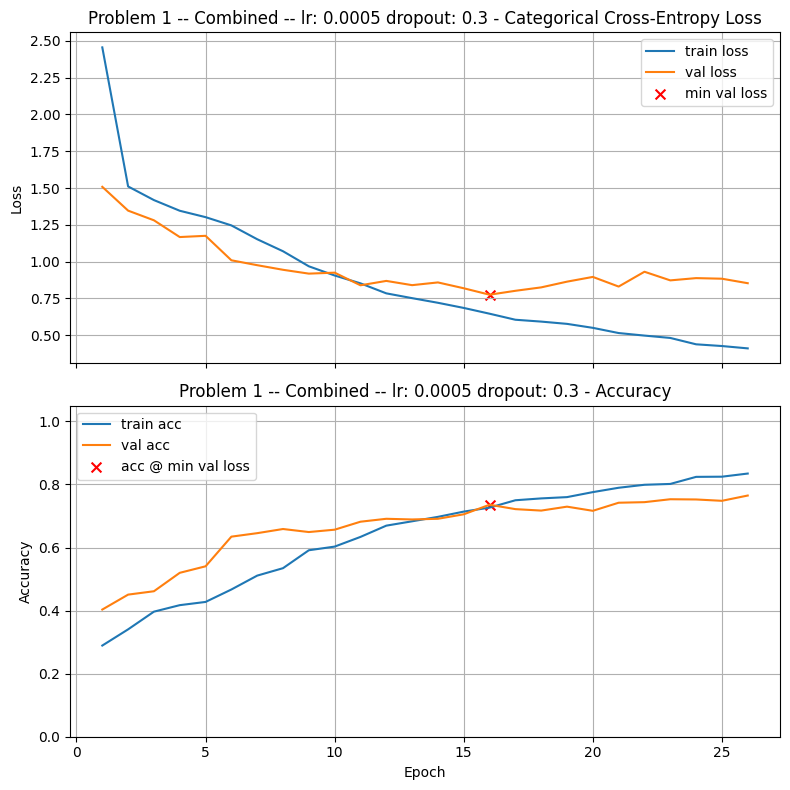

Final Training Loss:            0.4109
Final Training Accuracy:        0.8346
Final Validation Loss:          0.8536
Final Validation Accuracy:      0.7649
Minimum Validation Loss:        0.7755 (Epoch 16)
Validation Accuracy @ Min Loss: 0.7357

Test Loss: 0.7615
Test Accuracy: 0.7430

Validation-Test Gap (accuracy): 0.007339

Execution Time: 00:01:04


In [9]:
# Your code here, add additional cells if you wish

he = initializers.HeNormal()

# Baseline model (copy this into the next cell as starting point)
model_baseline = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_baseline, title="Problem 1 -- Baseline CNN")

# Tweak 1: Adjust learning rate (e.g., to 0.0005)
new_lr = 5e-4
model_tweak1 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_tweak1, lr_schedule=new_lr, title=f"Problem 1 -- Tweak 1 -- lr: {new_lr}")

# Tweak 2: Change width of Conv2D layers (e.g., 32->64, 64->128)
model_tweak2 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_tweak2, title="Problem 1 -- Tweak 2 -- wider Conv2D")

# Tweak 6: Modify dropout rate (e.g., to 0.3)
new_dropout = 0.3
model_tweak3 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(new_dropout),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_tweak3, title=f"Problem 1 -- Tweak 6 -- dropout: {new_dropout}")

# Optional: Combine tweaks (e.g., lower lr and lower dropout)
model_combined = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(new_dropout),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_combined, lr_schedule=new_lr, title=f"Problem 1 -- Combined -- lr: {new_lr} dropout: {new_dropout}")

In [41]:
# Soft coding으로 a1a, a1b 추출 (tweaks vs. baseline 비교, a1b fallback to baseline if no improvement)
tweak_mapping = {
    "Problem 1 -- Tweak 1 -- lr: 0.0005": 1,
    "Problem 1 -- Tweak 2 -- wider Conv2D": 2,
    "Problem 1 -- Tweak 6 -- dropout: 0.3": 6
}

problem1_titles = [title for title in results if "Problem 1 -- Tweak" in title]

# Baseline val acc 찾기 (max of baseline titles)
baseline_titles = [t for t in results if "Baseline" in t]
baseline_acc = max(results[t][0] for t in baseline_titles) if baseline_titles else 0.0  # e.g., 0.7709
baseline_title = max(baseline_titles, key=lambda t: results[t][0]) if baseline_titles else None  # for epoch if needed

if problem1_titles:
    best_title = max(problem1_titles, key=lambda t: results[t][0])
    best_tweak_acc = results[best_title][0]
    
    if best_tweak_acc > baseline_acc:
        a1a = tweak_mapping.get(best_title, 0)
        a1b = best_tweak_acc
    else:
        a1a = 0
        a1b = baseline_acc  # Updated: fallback to baseline acc when no improvement
    
    print(f'a1a = {a1a}')
    print(f'a1b = {a1b:.4f}')
else:
    print("No Problem 1 results yet. Run the experiments first!")
    a1a = 0
    a1b = 0.0

a1a = 0
a1b = 0.7709


### Graded Questions

In [43]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 0             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 0


In [45]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a. 

a1b = baseline_acc            # Replace 0.0 with your answer

In [46]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7709


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence. 

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer. 
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design. 
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.




Problem 2 -- With Batch Normalization



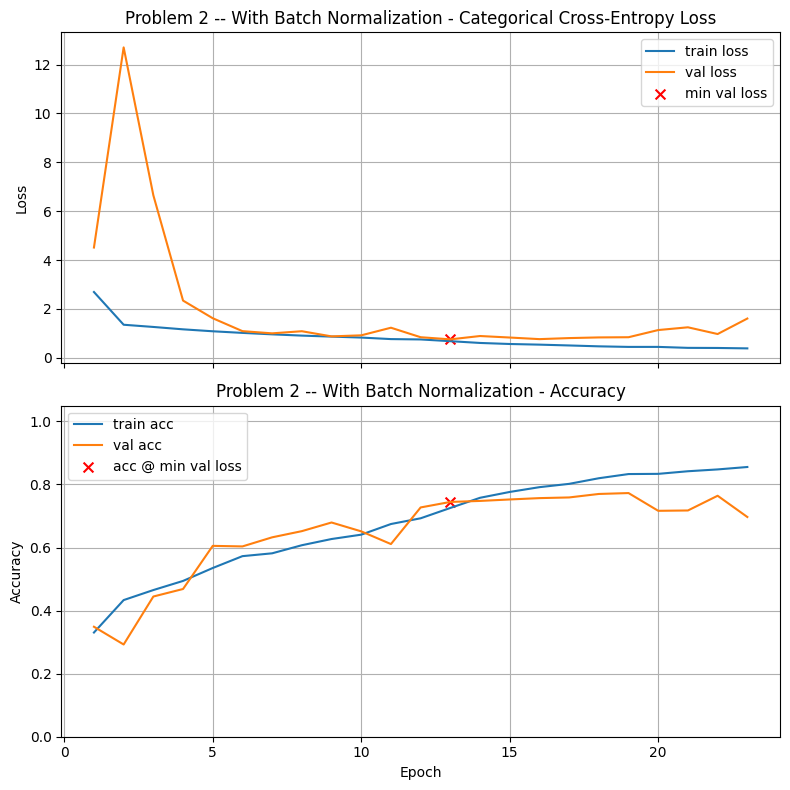

Final Training Loss:            0.3885
Final Training Accuracy:        0.8553
Final Validation Loss:          1.6094
Final Validation Accuracy:      0.6968
Minimum Validation Loss:        0.7579 (Epoch 13)
Validation Accuracy @ Min Loss: 0.7446

Test Loss: 0.7588
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.006100

Execution Time: 00:01:07

Problem 2 -- BN before Activation



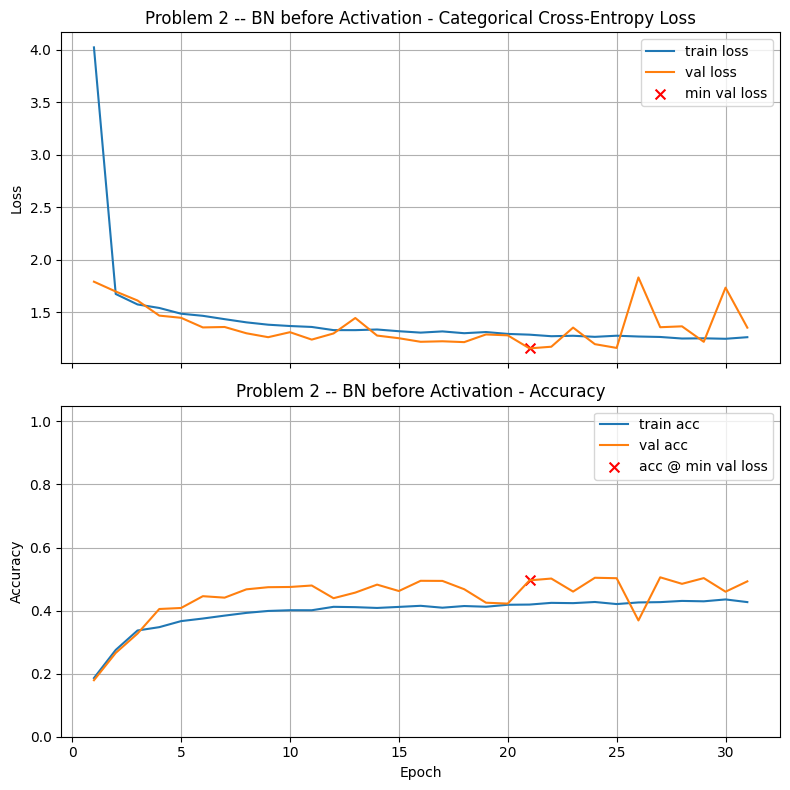

Final Training Loss:            1.2630
Final Training Accuracy:        0.4269
Final Validation Loss:          1.3537
Final Validation Accuracy:      0.4927
Minimum Validation Loss:        1.1565 (Epoch 21)
Validation Accuracy @ Min Loss: 0.4959

Test Loss: 1.1535
Test Accuracy: 0.4830

Validation-Test Gap (accuracy): 0.012903

Execution Time: 00:01:29

Problem 2 -- BN with momentum 0.9



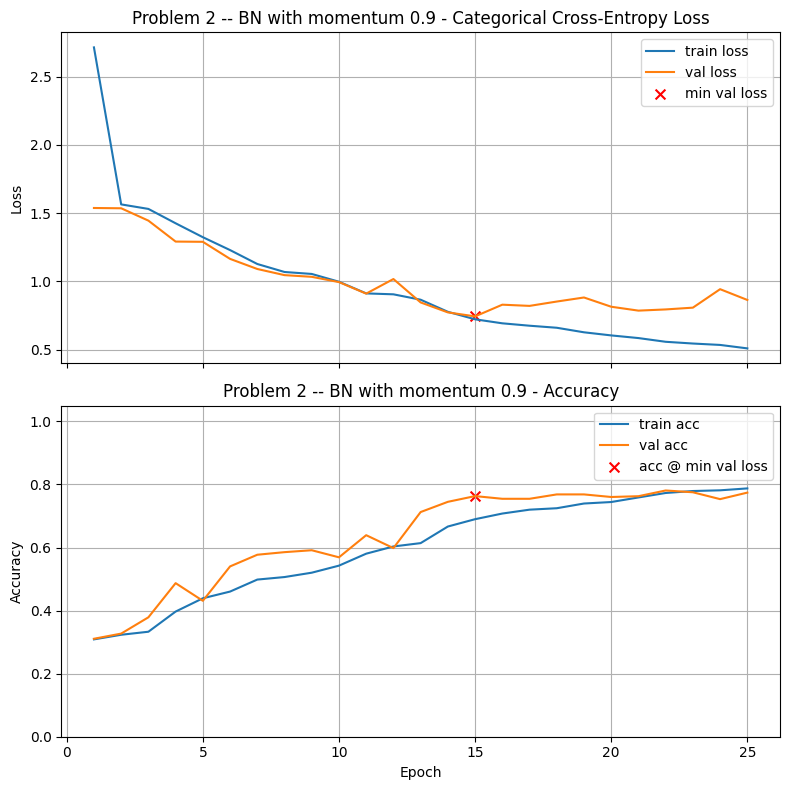

Final Training Loss:            0.5102
Final Training Accuracy:        0.7875
Final Validation Loss:          0.8649
Final Validation Accuracy:      0.7741
Minimum Validation Loss:        0.7446 (Epoch 15)
Validation Accuracy @ Min Loss: 0.7631

Test Loss: 0.7131
Test Accuracy: 0.7770

Validation-Test Gap (accuracy): 0.013908

Execution Time: 00:01:12


In [47]:
he = initializers.HeNormal()

# Copy best from Problem 1 (since no tweak improved, use baseline with your tested dropout 0.3; adjust if needed)
model_bn = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(),  # Add BN after Conv (after activation)
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.3),  # From your Problem 1 best attempt
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_bn, title="Problem 2 -- With Batch Normalization")

# Optional: BN before activation
model_bn_before_act = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', kernel_initializer=he),  # No act
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), padding='same', kernel_initializer=he),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_bn_before_act, title="Problem 2 -- BN before Activation")

# Optional: Momentum tweak (0.9)
model_bn_momentum = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_bn_momentum, title="Problem 2 -- BN with momentum 0.9")

In [56]:
# Soft coding for a2a, a2b (BN tweaks vs. Problem 1 best, a2b to P2 best if no improvement)
tweak_mapping_p2 = {
    "Problem 2 -- With Batch Normalization": 1,  # standard
    "Problem 2 -- BN before Activation": 2,
    "Problem 2 -- BN with momentum 0.9": 3
}

problem2_titles = [t for t in results if "Problem 2" in t]

# P1 best acc
problem1_best_acc = max(results[t][0] for t in results if "Problem 1" in t) if any("Problem 1" in t for t in results) else 0.0

if problem2_titles:
    best_p2_title = max(problem2_titles, key=lambda t: results[t][0])
    best_p2_acc = results[best_p2_title][0]
    
    if best_p2_acc > problem1_best_acc:
        a2a = tweak_mapping_p2.get(best_p2_title, 0)
    else:
        a2a = 0  # no improvement
    
    a2b = best_p2_acc  # Always P2 best acc (new model value)
    
    print(f'a2a = {a2a}')
    print(f'a2b = {a2b:.4f}')
else:
    print("Run Problem 2 first!")
    a2a = 0
    a2b = 0.0

a2a = 0
a2b = 0.7631


### Graded Questions

In [49]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [50]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 


a2a = 0


In [57]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem) 

a2b = best_p2_acc             # Replace 0.0 with your answer

In [58]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7631


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video, 
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique). 

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block. 

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design. 
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.




Problem 3 -- Global Average Pooling



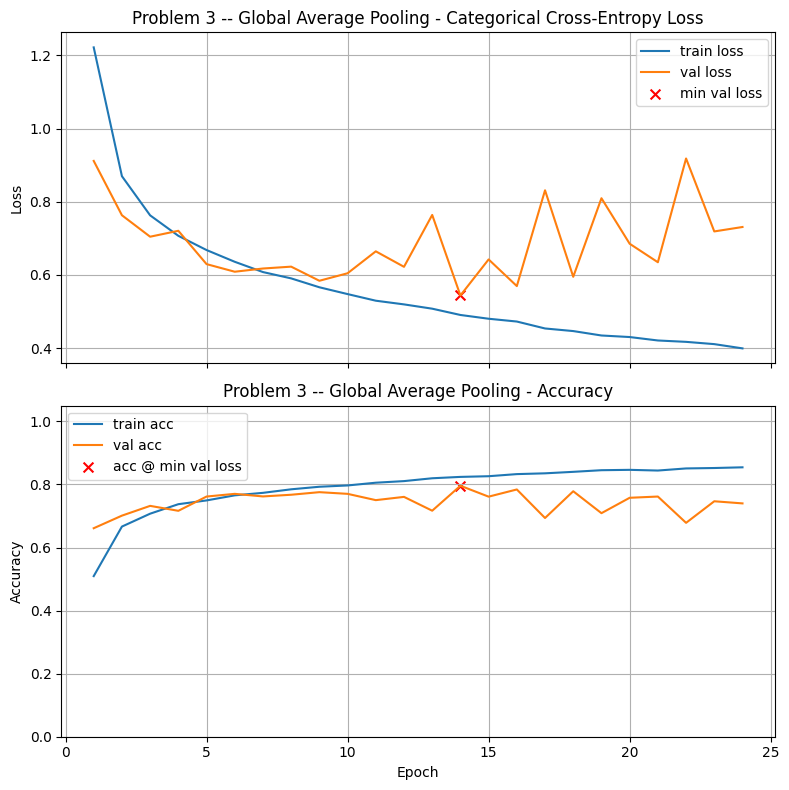

Final Training Loss:            0.3994
Final Training Accuracy:        0.8544
Final Validation Loss:          0.7310
Final Validation Accuracy:      0.7399
Minimum Validation Loss:        0.5440 (Epoch 14)
Validation Accuracy @ Min Loss: 0.7959

Test Loss: 0.5263
Test Accuracy: 0.8043

Validation-Test Gap (accuracy): 0.008466

Execution Time: 00:01:09

Problem 3 -- GAP with L2 Reg (P1 Tweak 5)



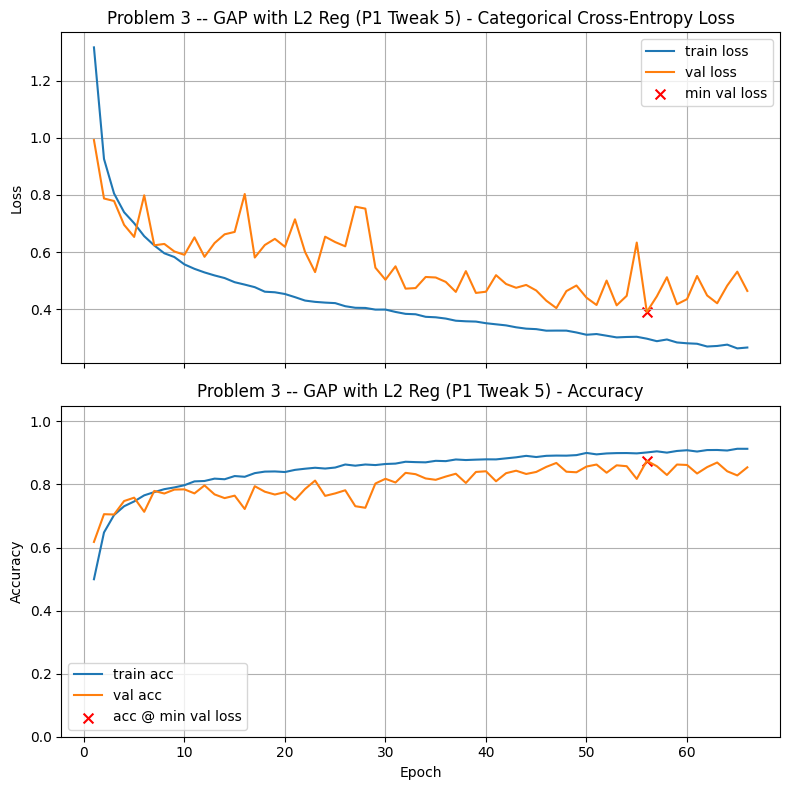

Final Training Loss:            0.2653
Final Training Accuracy:        0.9131
Final Validation Loss:          0.4636
Final Validation Accuracy:      0.8543
Minimum Validation Loss:        0.3900 (Epoch 56)
Validation Accuracy @ Min Loss: 0.8750

Test Loss: 0.3936
Test Accuracy: 0.8697

Validation-Test Gap (accuracy): 0.005289

Execution Time: 00:02:49

Problem 3 -- GAP with Smaller Dense (P1 Tweak 4)



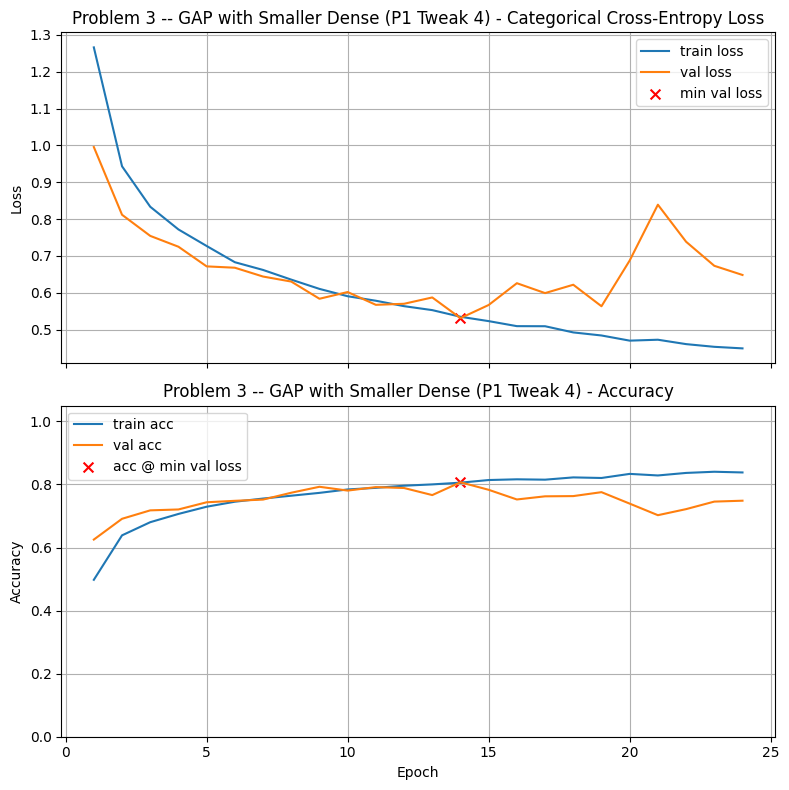

Final Training Loss:            0.4491
Final Training Accuracy:        0.8381
Final Validation Loss:          0.6484
Final Validation Accuracy:      0.7485
Minimum Validation Loss:        0.5312 (Epoch 14)
Validation Accuracy @ Min Loss: 0.8069

Test Loss: 0.5053
Test Accuracy: 0.8067

Validation-Test Gap (accuracy): 0.000245

Execution Time: 00:01:06

Problem 3 -- Global Max Pooling



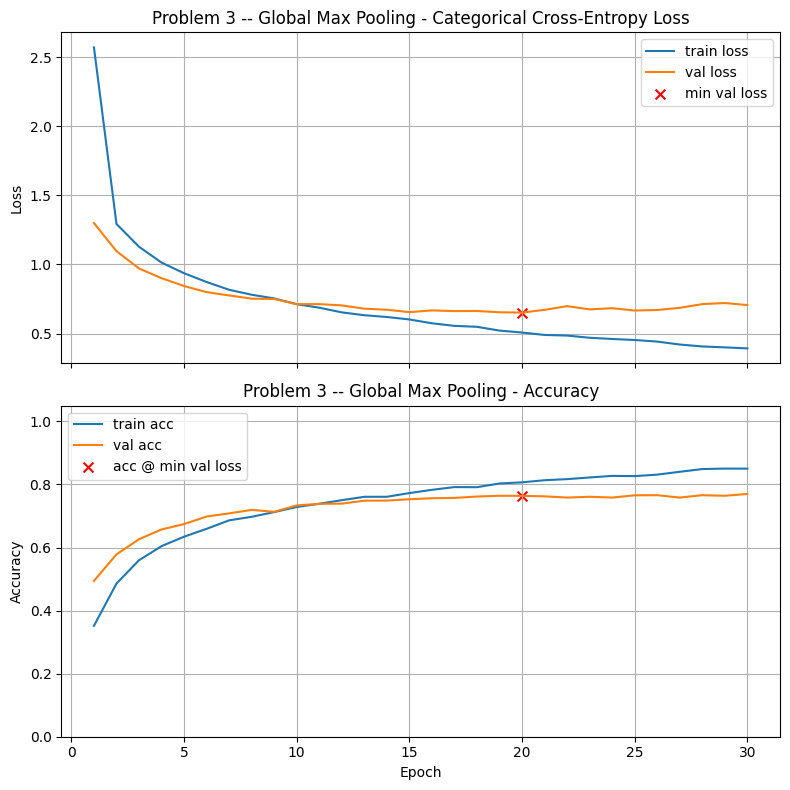

Final Training Loss:            0.3923
Final Training Accuracy:        0.8502
Final Validation Loss:          0.7061
Final Validation Accuracy:      0.7699
Minimum Validation Loss:        0.6515 (Epoch 20)
Validation Accuracy @ Min Loss: 0.7638

Test Loss: 0.6353
Test Accuracy: 0.7740

Validation-Test Gap (accuracy): 0.010195

Execution Time: 00:01:22


In [61]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)  # For P1 tweak 5

# Copy from Problem 2 best (momentum 0.9), replace Flatten block with GAP
model_gap = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),  # As per example
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.GlobalAveragePooling2D(),  # Replace Flatten + part of dense block
    
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_gap, title="Problem 3 -- Global Average Pooling")

# Apply P1 Tweak 5: Add L2 to Dense (on GAP model)
model_gap_l2 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(64, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),  # P1 tweak 5
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_gap_l2, title="Problem 3 -- GAP with L2 Reg (P1 Tweak 5)")

# Apply P1 Tweak 4: Change Dense width to 32 (on GAP model)
model_gap_small_dense = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(32, activation='relu', kernel_initializer=he),  # P1 tweak 4: width change
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_gap_small_dense, title="Problem 3 -- GAP with Smaller Dense (P1 Tweak 4)")

# Optional: Global Max Pooling
model_gmp = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.GlobalMaxPooling2D(),
    
    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

train_and_test(model_gmp, title="Problem 3 -- Global Max Pooling")

In [63]:
# Soft coding for a3a, a3b (P3 with P1 tweaks vs. Problem 2 best)
tweak_mapping_p3 = {
    "Problem 3 -- Global Average Pooling": 1,  # Tweak 1: standard GAP
    "Problem 3 -- Global Max Pooling": 2,  # Tweak 2: GMP variant
    "Problem 3 -- GAP with L2 Reg (P1 Tweak 5)": 3,  # Tweak 3: GAP + L2 reg (inspired by P1 5)
    "Problem 3 -- GAP with Smaller Dense (P1 Tweak 4)": 4   # Tweak 4: GAP + smaller Dense (inspired by P1 4)
}

problem3_titles = [t for t in results if "Problem 3" in t]

# P2 best acc (max of P2)
problem2_best_acc = max(results[t][0] for t in results if "Problem 2" in t) if any("Problem 2" in t for t in results) else 0.0

if problem3_titles:
    best_p3_title = max(problem3_titles, key=lambda t: results[t][0])
    best_p3_acc = results[best_p3_title][0]
    
    if best_p3_acc > problem2_best_acc:
        a3a = tweak_mapping_p3.get(best_p3_title, 0)
    else:
        a3a = 0
    
    a3b = best_p3_acc  # P3 best acc (new model value)
    
    print(f'a3a = {a3a}')
    print(f'a3b = {a3b:.4f}')
else:
    print("Run Problem 3 first!")
    a3a = 0
    a3b = 0.0

a3a = 3
a3b = 0.8750


### Graded Questions

In [64]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 3             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [65]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 


a3a = 3


In [66]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem) 

a3b = best_p3_acc             # Replace 0.0 with your answer

In [67]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8750


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!). 
* Answer the graded questions.




Problem 4 -- With ReduceLROnPlateau


Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 59: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 63: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 69: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 79: ReduceLROnPlateau reducing learning rate to 1e-05.


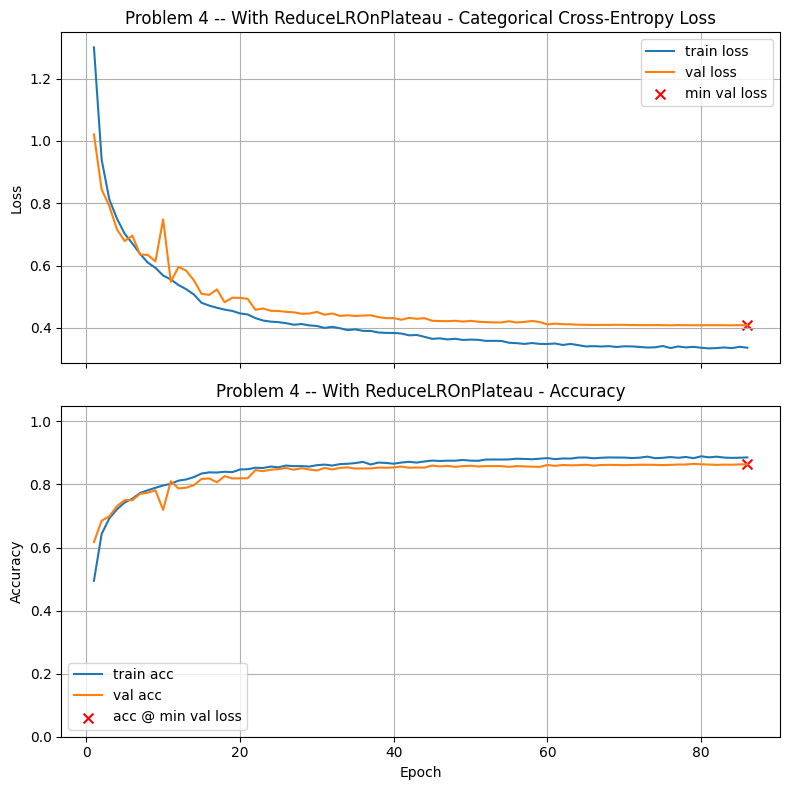

Final Training Loss:            0.3368
Final Training Accuracy:        0.8858
Final Validation Loss:          0.4086
Final Validation Accuracy:      0.8639
Minimum Validation Loss:        0.4086 (Epoch 86)
Validation Accuracy @ Min Loss: 0.8639

Test Loss: 0.3935
Test Accuracy: 0.8660

Validation-Test Gap (accuracy): 0.003870

Execution Time: 00:03:42

Problem 4 -- LR Sched: patience 5, factor 0.1


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 24: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 39: ReduceLROnPlateau reducing learning rate to 1e-05.


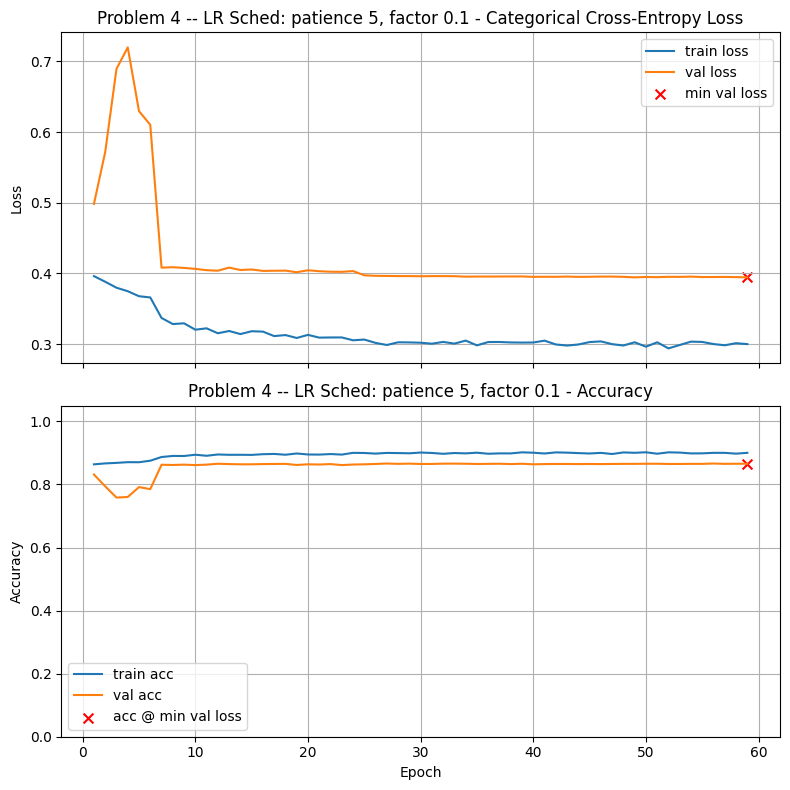

Final Training Loss:            0.3000
Final Training Accuracy:        0.9003
Final Validation Loss:          0.3944
Final Validation Accuracy:      0.8657
Minimum Validation Loss:        0.3944 (Epoch 59)
Validation Accuracy @ Min Loss: 0.8657

Test Loss: 0.3798
Test Accuracy: 0.8757

Validation-Test Gap (accuracy): 0.010330

Execution Time: 00:02:30

Problem 4 -- LR Sched: monitor val_accuracy


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


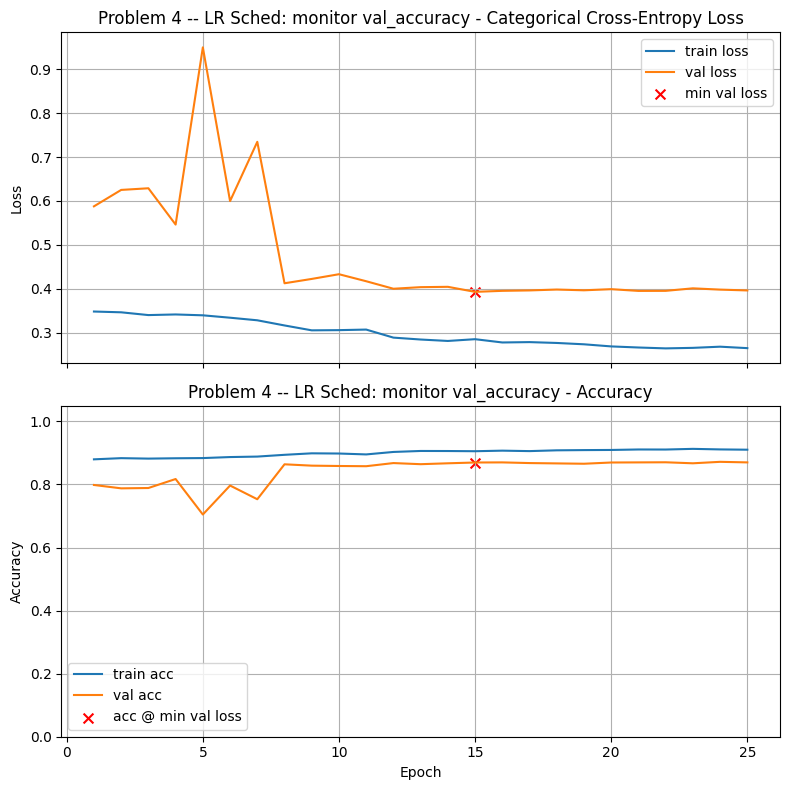

Final Training Loss:            0.2652
Final Training Accuracy:        0.9102
Final Validation Loss:          0.3964
Final Validation Accuracy:      0.8700
Minimum Validation Loss:        0.3932 (Epoch 15)
Validation Accuracy @ Min Loss: 0.8696

Test Loss: 0.3754
Test Accuracy: 0.8793

Validation-Test Gap (accuracy): 0.009722

Execution Time: 00:01:08


In [70]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Copy P3 best (e.g., GAP with L2 reg)
model_lr_sched = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(64, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Standard ReduceLROnPlateau (as given)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-5,
    verbose=1  # Log LR changes
)

train_and_test(model_lr_sched, callbacks=[lr_scheduler], title="Problem 4 -- With ReduceLROnPlateau")

# Tweak 1: Patience=5, Factor=0.1
lr_scheduler_tweak1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # More aggressive reduction
    patience=5,
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-5,
    verbose=1
)

model_lr_sched_tweak1 = models.Sequential(model_lr_sched.layers)
train_and_test(model_lr_sched_tweak1, callbacks=[lr_scheduler_tweak1], title="Problem 4 -- LR Sched: patience 5, factor 0.1")

# Tweak 2: Monitor val_accuracy
lr_scheduler_tweak2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-5,
    verbose=1
)

model_lr_sched_tweak2 = models.Sequential(model_lr_sched.layers)
train_and_test(model_lr_sched_tweak2, callbacks=[lr_scheduler_tweak2], title="Problem 4 -- LR Sched: monitor val_accuracy")

In [79]:
# Soft coding for a4a, a4b (P4 tweaks vs. P3 best, a4a as factor float)
factor_mapping_p4 = {
    "Problem 4 -- With ReduceLROnPlateau": 0.5,  # Standard factor
    "Problem 4 -- LR Sched: patience 5, factor 0.1": 0.1,  # Tweak factor
    "Problem 4 -- LR Sched: monitor val_accuracy": 0.5  # Factor 0.5
}

problem4_titles = [t for t in results if "Problem 4" in t]

# P3 best acc
problem3_best_acc = max(results[t][0] for t in results if "Problem 3" in t) if any("Problem 3" in t for t in results) else 0.0

if problem4_titles:
    best_p4_title = max(problem4_titles, key=lambda t: results[t][0])
    best_p4_acc = results[best_p4_title][0]
    
    if best_p4_acc > problem3_best_acc:
        a4a = factor_mapping_p4.get(best_p4_title, 0.0)  # Best factor value
        a4b = best_p4_acc  # Val acc from best model (new value)
    else:
        a4a = 0.0  # No help
        a4b = problem3_best_acc  # Fallback to P3 best acc
    
    print(f'a4a = {a4a}')
    print(f'a4b = {a4b:.4f}')
else:
    print("Run Problem 4 first!")
    a4a = 0.0
    a4b = 0.0

a4a = 0.0
a4b = 0.8750


### Graded Questions

In [72]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.0             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [73]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.2f}') 

a4a = 0.00


In [75]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem) 

a4b = problem3_best_acc             # Replace 0.0 with your answer

In [76]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8750


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see:

        https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

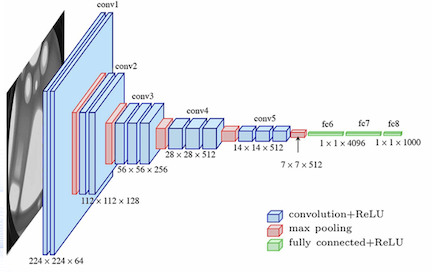


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss** 
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect. 




Problem 5 -- VGG LR 0.01



2025-09-25 09:20:00.946409: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-25 09:20:01.518350: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1600', 64 bytes spill stores, 64 bytes spill loads

2025-09-25 09:20:25.871458: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-25 09:20:26.038065: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

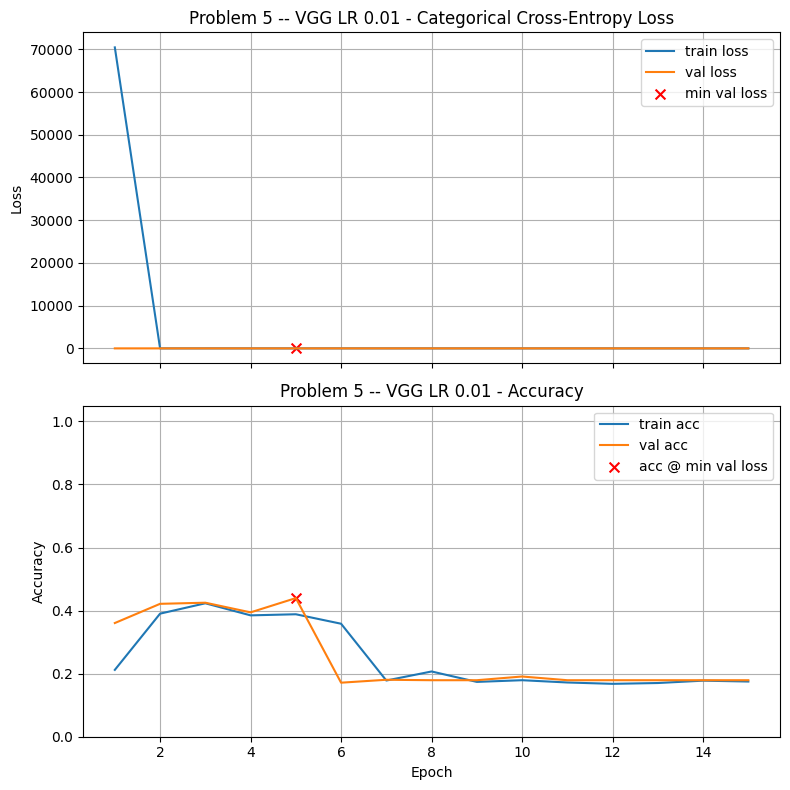

Final Training Loss:            1.8172
Final Training Accuracy:        0.1750
Final Validation Loss:          1.8162
Final Validation Accuracy:      0.1792
Minimum Validation Loss:        1.2818 (Epoch 5)
Validation Accuracy @ Min Loss: 0.4396


2025-09-25 09:23:40.195550: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-25 09:23:40.385676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 16 bytes spill stores, 16 bytes spill loads

2025-09-25 09:23:40.505614: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_183', 8 bytes spill stores, 8 bytes spill loads

2025-09-25 09:23:42.940961: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set do


Test Loss: 1.2880
Test Accuracy: 0.4230

Validation-Test Gap (accuracy): 0.016615

Execution Time: 00:03:47

Problem 5 -- VGG LR 0.003



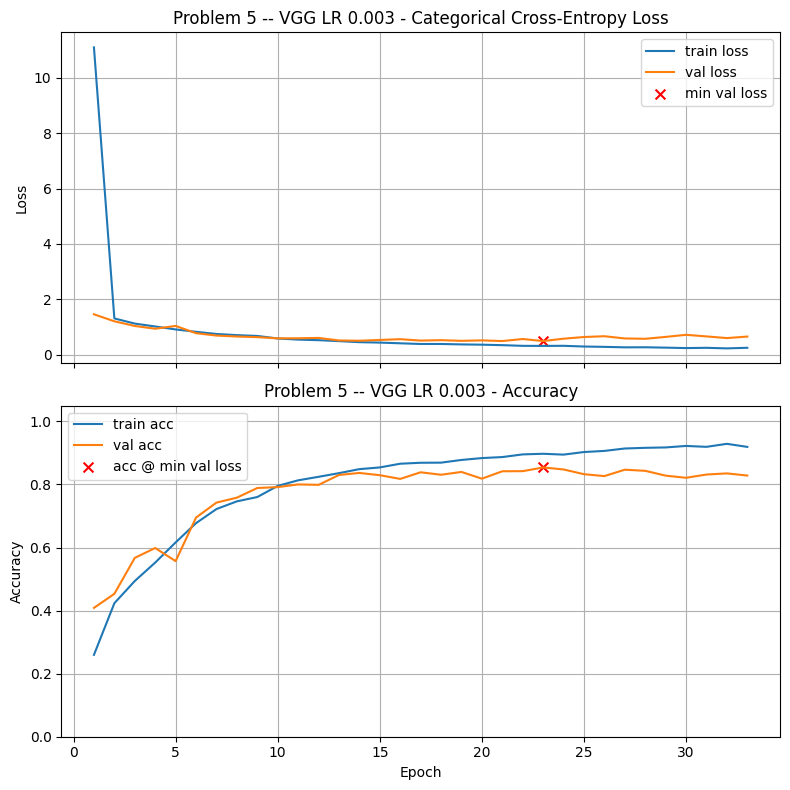

Final Training Loss:            0.2484
Final Training Accuracy:        0.9191
Final Validation Loss:          0.6531
Final Validation Accuracy:      0.8283
Minimum Validation Loss:        0.4909 (Epoch 23)
Validation Accuracy @ Min Loss: 0.8539

Test Loss: 0.4949
Test Accuracy: 0.8460

Validation-Test Gap (accuracy): 0.007937

Execution Time: 00:06:53

Problem 5 -- VGG LR 0.001



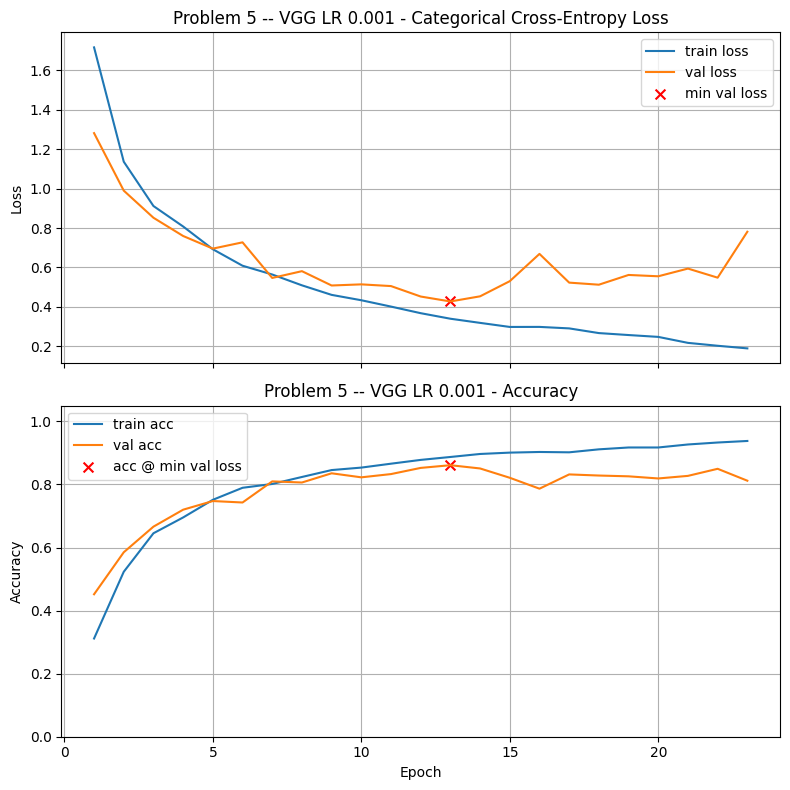

Final Training Loss:            0.1895
Final Training Accuracy:        0.9379
Final Validation Loss:          0.7811
Final Validation Accuracy:      0.8119
Minimum Validation Loss:        0.4275 (Epoch 13)
Validation Accuracy @ Min Loss: 0.8611

Test Loss: 0.4083
Test Accuracy: 0.8640

Validation-Test Gap (accuracy): 0.002938

Execution Time: 00:05:01

Problem 5 -- VGG LR 0.0003



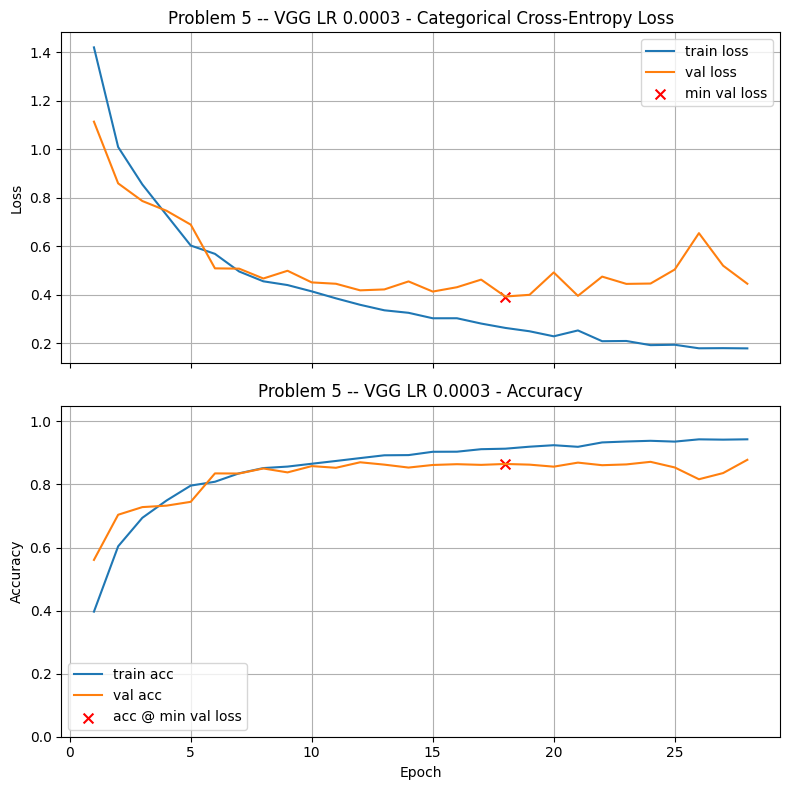

Final Training Loss:            0.1789
Final Training Accuracy:        0.9432
Final Validation Loss:          0.4454
Final Validation Accuracy:      0.8782
Minimum Validation Loss:        0.3927 (Epoch 18)
Validation Accuracy @ Min Loss: 0.8650

Test Loss: 0.3698
Test Accuracy: 0.8737

Validation-Test Gap (accuracy): 0.008686

Execution Time: 00:05:47

Problem 5 -- VGG LR 0.0001



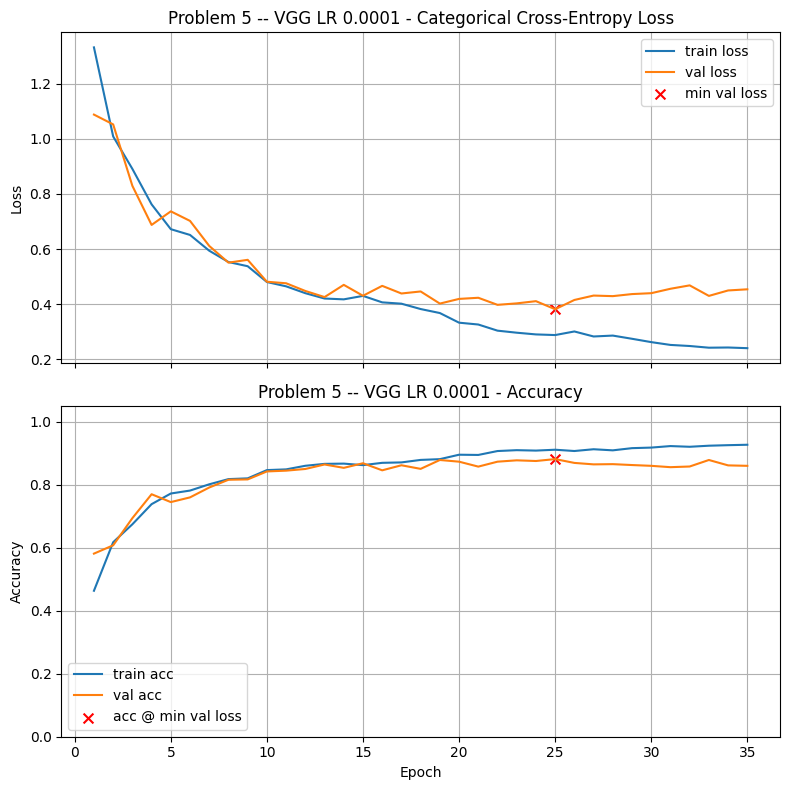

Final Training Loss:            0.2408
Final Training Accuracy:        0.9265
Final Validation Loss:          0.4541
Final Validation Accuracy:      0.8596
Minimum Validation Loss:        0.3820 (Epoch 25)
Validation Accuracy @ Min Loss: 0.8810

Test Loss: 0.3818
Test Accuracy: 0.8787

Validation-Test Gap (accuracy): 0.002345

Execution Time: 00:07:14

Problem 5 -- VGG LR 3e-05



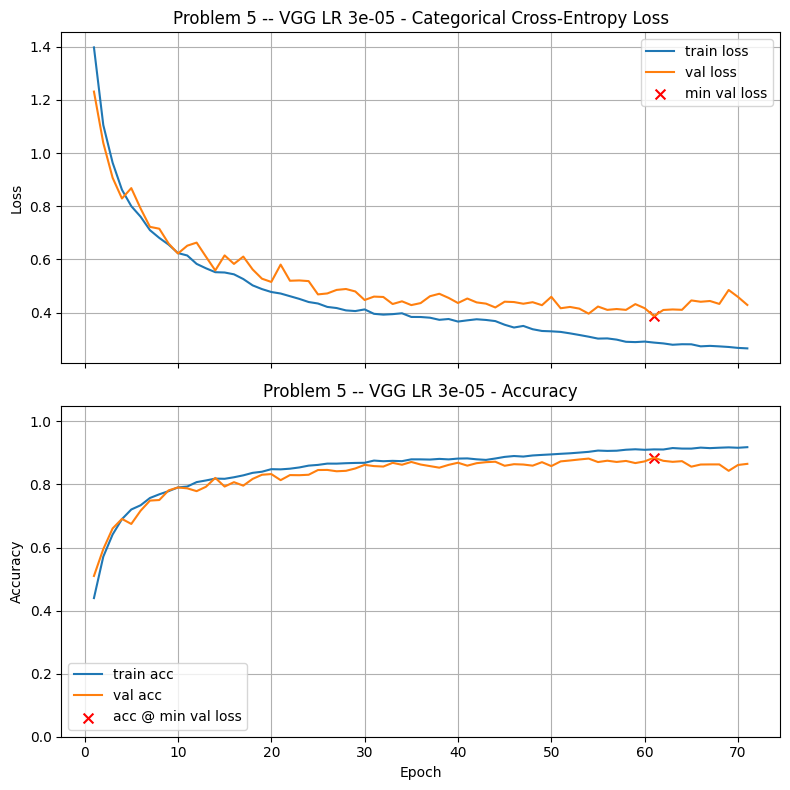

Final Training Loss:            0.2657
Final Training Accuracy:        0.9182
Final Validation Loss:          0.4290
Final Validation Accuracy:      0.8653
Minimum Validation Loss:        0.3871 (Epoch 61)
Validation Accuracy @ Min Loss: 0.8849

Test Loss: 0.4008
Test Accuracy: 0.8807

Validation-Test Gap (accuracy): 0.004264

Execution Time: 00:14:50

Problem 5 -- VGG LR 1e-05



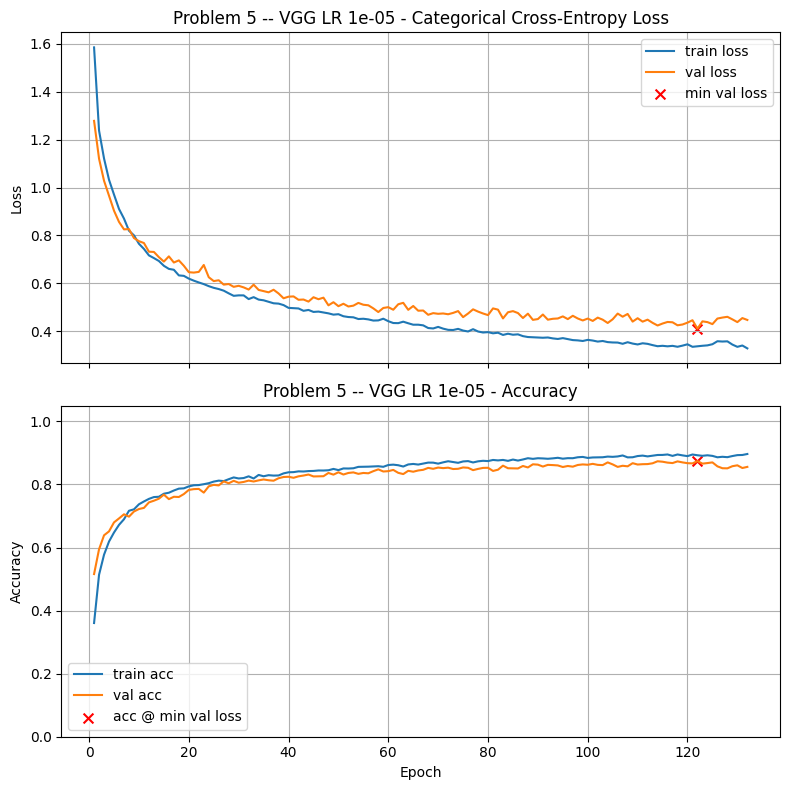

Final Training Loss:            0.3286
Final Training Accuracy:        0.8966
Final Validation Loss:          0.4473
Final Validation Accuracy:      0.8557
Minimum Validation Loss:        0.4110 (Epoch 122)
Validation Accuracy @ Min Loss: 0.8742

Test Loss: 0.4171
Test Accuracy: 0.8657

Validation-Test Gap (accuracy): 0.008576

Execution Time: 00:27:07


In [83]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

# train_and_test(model_vgg_16,lr_schedule=1e-3,title="VGG-style Large")

from copy import deepcopy

# Soft coding: LR list for sweep
lr_list = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]

for lr in lr_list:
    model_vgg_copy = deepcopy(model_vgg_16)  # Independent copy
    title = f"Problem 5 -- VGG LR {lr}"
    train_and_test(model_vgg_copy, lr_schedule=lr, title=title)


In [84]:
# Soft coding for a5a, a5b (best LR from P5 sweep)
problem5_titles = [t for t in results if "Problem 5 -- VGG LR" in t]

if problem5_titles:
    best_p5_title = max(problem5_titles, key=lambda t: results[t][0])
    best_p5_acc = results[best_p5_title][0]
    
    # Extract LR from title (soft coding parse)
    lr_str = best_p5_title.split("LR ")[1]  # e.g., "0.001"
    a5a = float(lr_str)  # Best LR float
    
    a5b = best_p5_acc  # Best val acc
    
    print(f'a5a = {a5a:.8f}')
    print(f'a5b = {a5b:.4f}')
else:
    print("Run Problem 5 first!")
    a5a = 0.0
    a5b = 0.0

a5a = 0.00003000
a5b = 0.8849


### Graded Questions

In [31]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 0.0             # Replace with your best learning rate

In [32]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.8f}') 

a5a = 0.00000000


In [33]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem) 

a5b = 0.0              # Replace 0.0 with your answer           

In [34]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.0000


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [85]:
print_results()

Problem 5 -- VGG LR 3e-05               	0.8849	61
Problem 5 -- VGG LR 0.0001              	0.8810	25
Problem 3 -- GAP with L2 Reg (P1 Tweak 5)	0.8750	56
Problem 5 -- VGG LR 1e-05               	0.8742	122
Problem 4 -- LR Sched: monitor val_accuracy	0.8696	15
Problem 4 -- LR Sched: patience 5, factor 0.1	0.8657	59
Problem 5 -- VGG LR 0.0003              	0.8650	18
Problem 4 -- With ReduceLROnPlateau     	0.8639	86
Problem 5 -- VGG LR 0.001               	0.8611	13
Problem 5 -- VGG LR 0.003               	0.8539	23
Problem 3 -- GAP with L2 Reg            	0.8457	25
Problem 3 -- GAP with Smaller Head      	0.8390	19
Problem 3 -- GAP with Smaller Dense (P1 Tweak 4)	0.8069	14
Problem 3 -- Global Average Pooling     	0.7959	14
Problem 1 -- Baseline CNN               	0.7709	21
Baseline Model                          	0.7677	31
Problem 3 -- Global Max Pooling         	0.7638	20
Problem 2 -- BN with momentum 0.9       	0.7631	15
Problem 2 -- With Batch Normalization   	0.7446	13
Problem 1 -- 